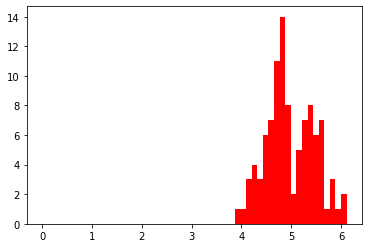

In [179]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import theano.tensor as tt

np.random.seed(12345)
# generate some data
K = 2
mu_1 = 2
sigma_1 = 1
mu_2 = 5
sigma_2 = 0.5

mix_1 = ss.norm(loc=mu_1, scale=sigma_1)
mix_2 = ss.norm(loc=mu_2, scale=sigma_2)

n1 = 100
n2 = 100
X = np.concatenate( (
    mix_1.rvs(size=n1), # random variates
    mix_2.rvs(size=n2),
) )

Z = np.concatenate( ( # true mixture component labels
    0*np.ones((n1,1)),
    1*np.ones((n2,1))
)).astype(int)

# randomly permute the data
rand_idx = np.arange(0, X.shape[0], step=1)
np.random.shuffle(rand_idx)
X = X[rand_idx]
Z = Z[rand_idx]

fig, ax = plt.subplots()
k_idx = np.asarray(Z==1).nonzero()[0]
ax.hist(X[k_idx], color="r", bins=20)
k_idx = np.asarray(Z==2).nonzero()[0]
ax.hist(X[k_idx], color="g", bins=20)
plt.show()

In [180]:
with pm.Model() as model:
    
    # cluster proportion p(theta|alpha)
    theta = pm.Dirichlet("theta", 
        a = np.array([1.,1.]),
        shape=2, # one for each cmpt
    )

    # cluster means p(mu|sigma^2)
    mu = pm.Normal("mu", mu=np.array([0,0]), sigma=15, shape=2)
    # need to break the symmetry, otherwise different chains might swap the mus
    order_means_potential = pm.Potential('order_means_potential',
        tt.switch(mu[1]-mu[0] < 0, -np.inf, 0))


    # latent var z_i p(z_i|theta)
    zs = pm.Categorical("zs", p=theta, shape=X.shape[0]) # one for each obs

    # measurement noise
    sd = pm.Uniform('sd', lower=0, upper=20)

    # likelihood: where the data comes in p(x|z)
    y_like = pm.Normal("y_like", 
        mu=mu[zs],
        sigma=sd, 
        observed=X, # where the data enters in
    )

In [181]:
with model:
    s1 = pm.Metropolis(vars=[theta, sd, mu])
    s2 = pm.ElemwiseCategorical(vars=[zs], values=[0,1])
    trace = pm.sample(10000, step=[s1,s2], tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [mu]
>>Metropolis: [sd]
>>Metropolis: [theta]
>ElemwiseCategorical: [zs]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 105 seconds.
The number of effective samples is smaller than 10% for some parameters.


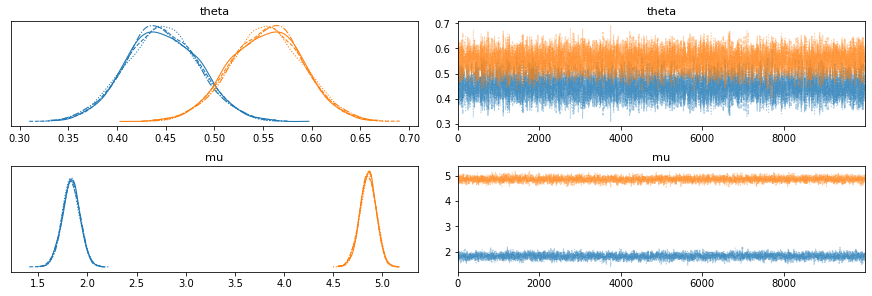

In [182]:
pm.traceplot(trace, var_names=["theta", "mu"]);

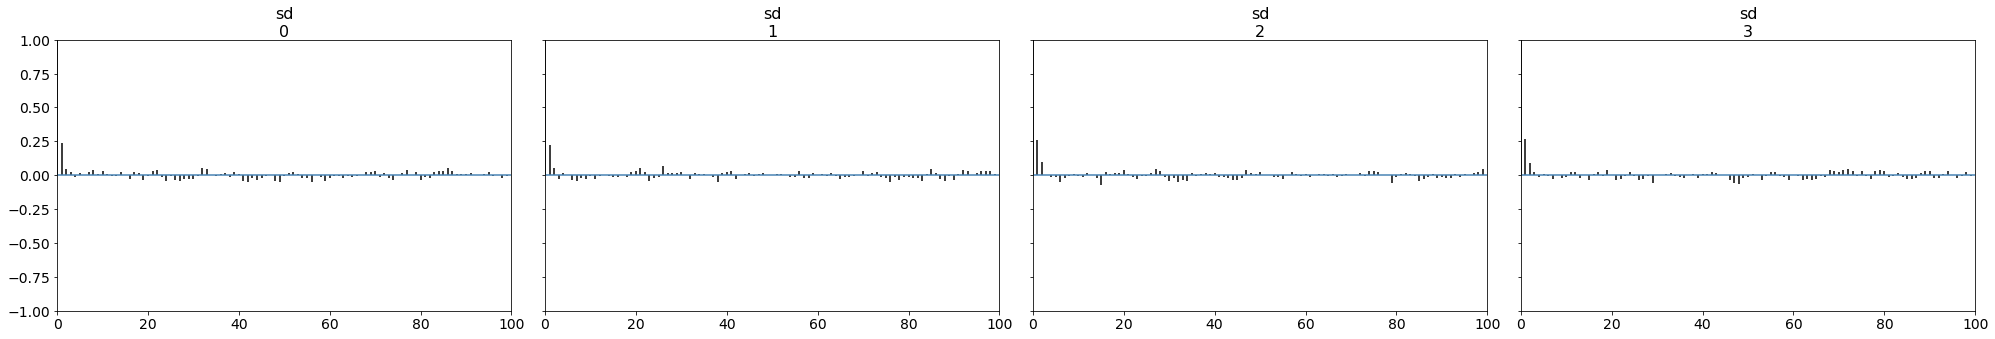

In [183]:
pm.autocorrplot(trace[::5], varnames=["sd"]);

true cluster: [0]
  data value: 3.82


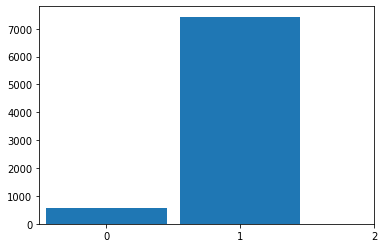

In [184]:
def cluster_posterior(i=0):
    print('true cluster:', Z[i])
    print('  data value:', np.round(X[i],2))
    plt.hist(trace['zs'][::5,i], bins=[-.5,.5,1.5,2.5,], rwidth=.9)
    plt.axis(xmin=-.5, xmax=1.5)
    plt.xticks([0,1,2])
cluster_posterior(150)

In [185]:
burnin = 2000
Z_pred = ss.mode(trace["zs"][burnin:,:],axis=0)[0].flatten()
Z_exact = (~Z.flatten().astype(bool)).astype(int)


In [186]:
np.sum(Z_pred == Z_exact) / len(Z_pred)

0.055

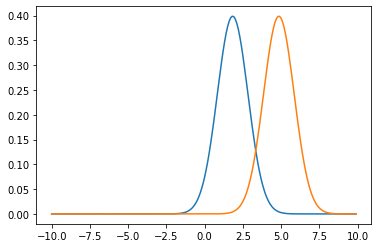

In [187]:
mu1, mu2 = np.mean(trace["mu"], axis=0)

t = np.arange(-10,10,0.1)
x1 = ss.norm.pdf(t, loc=mu1, scale=1)
x2 = ss.norm.pdf(t, loc=mu2, scale=1)

fig, ax = plt.subplots()
ax.plot(t,x1)
ax.plot(t,x2)

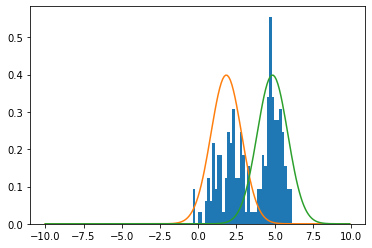

In [192]:
fig, ax = plt.subplots()
# k_idx = np.asarray(Z==0).nonzero()[0]
# ax.hist(X[k_idx], color="r", bins=20)
# k_idx = np.asarray(Z==1).nonzero()[0]
# ax.hist(X[k_idx], color="g", bins=20)

ax.hist(X, bins=40, density=True)
ax.plot(t,x1)
ax.plot(t,x2)
plt.show()